In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Defining the tranform class for converting mnist image files
transform = transforms.ToTensor()

In [17]:
train_data = datasets.MNIST(root='data', train=True, transform=transform)

In [18]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [19]:
test_data = datasets.MNIST(root='data', train=False, transform=transform)

In [37]:
#Load data
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Builing a model for convolutional neural network

In [30]:
## Model Class

class ConvolutionalNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3, 1)  # input, output, filter, stride
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        
        #Fully connected layers
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        #second pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        # Flattening
        X = X.view(-1, 16*5*5)  # -1 is for varying batch size
        
        #Fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [31]:
ConvolutionalNN().parameters

<bound method Module.parameters of ConvolutionalNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

In [32]:
# Create an instance of the model

torch.manual_seed(41)

cnn_model = ConvolutionalNN()

In [33]:
cnn_model

ConvolutionalNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
# Loss Optimization

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

In [40]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0
    
    #Training
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1  #starting the batches at 1
        y_pred = cnn_model(X_train)  #getting the predicted values from the training set !matrix here is not flattened
        loss = criterion(y_pred, y_train) #measuring the loss
        
        predicted = torch.max(y_pred.data, 1)[1] #finds the maximum value along dimension 1 and accesses the second element of the tuple 
                                                 #returned by torch.max(), which contains the indices of the maximum values.
        batch_corrects = (predicted==y_train).sum()
        train_corr += batch_corrects
        
        #update params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    with torch.no_grad():  #weights are not updated
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = cnn_model(X_test)
            
            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted==y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} minutes')

Epoch: 0  Batch: 600  Loss: 0.12228913605213165
Epoch: 0  Batch: 1200  Loss: 0.003188498318195343
Epoch: 0  Batch: 1800  Loss: 0.0007747156778350472
Epoch: 0  Batch: 2400  Loss: 0.014211039058864117
Epoch: 0  Batch: 3000  Loss: 0.01345641165971756
Epoch: 0  Batch: 3600  Loss: 0.009994076564908028
Epoch: 0  Batch: 4200  Loss: 0.0039134849794209
Epoch: 0  Batch: 4800  Loss: 0.003715724451467395
Epoch: 0  Batch: 5400  Loss: 0.01206299476325512
Epoch: 0  Batch: 6000  Loss: 0.17568042874336243
Epoch: 1  Batch: 600  Loss: 0.0039933486841619015
Epoch: 1  Batch: 1200  Loss: 0.13874538242816925
Epoch: 1  Batch: 1800  Loss: 0.004636839032173157
Epoch: 1  Batch: 2400  Loss: 0.001155938720330596
Epoch: 1  Batch: 3000  Loss: 0.004312815144658089
Epoch: 1  Batch: 3600  Loss: 0.011701542884111404
Epoch: 1  Batch: 4200  Loss: 0.007058572024106979
Epoch: 1  Batch: 4800  Loss: 0.00014502699195872992
Epoch: 1  Batch: 5400  Loss: 0.4981679916381836
Epoch: 1  Batch: 6000  Loss: 0.011390486732125282
Epoch: 

### Visualising the losses

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


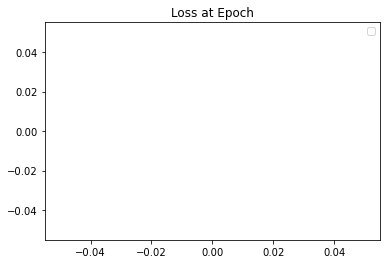

In [41]:
plt.plot(data=[td.item() for td in train_losses], label='Training losses')
plt.plot(data=test_losses, label='Validation losses')
plt.title('Loss at Epoch')
plt.legend()